In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

/Users/piyushpandita/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


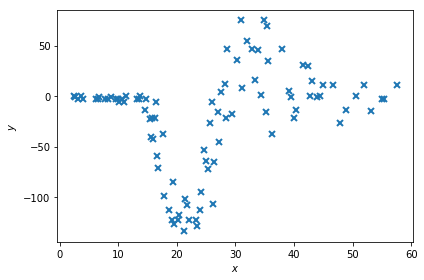

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
# k1 = hetero_kernels.RBF(1)
# k2 = hetero_kernels.RBF(1)
# k3 = hetero_kernels.RBF(1)
# m = hetero_gpmc.GPMCAdaptive(Xnorm, Y[:,None], k1, k2, k3)
k = gpflow.kernels.RBF(input_dim=1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale2D(Xnorm, Y[:,None], k, nonstat)

In [4]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp2D.V,[[0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.]],"N([0.],[1.])",(none)
adaptive_lengthscale_gp2D.V4,[[0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.]],"N([0.],[1.])",(none)
adaptive_lengthscale_gp2D.kern_type.lengthscales,[1.],None,+ve
adaptive_lengthscale_gp2D.kern_type.variance,[1.],None,+ve
adaptive_lengthscale_gp2D.likelihood.variance,[1.],None,+ve
adaptive_lengthscale_gp2D.nonstat.signal_variance,[1.],None,+ve


In [5]:
# #m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
# #m.kern1.variance.prior = gpflow.priors.Gamma(1.,1.)

# #m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
# #m.kern2.variance.prior = gpflow.priors.Gamma(1.,1.)

# #m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
# m.kern1.lengthscales = 1
# m.kern1.lengthscales.fixed = True
# m.kern1.variance = 1.
# m.kern1.variance.fixed = True

# #m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
# m.kern2.lengthscales = 1
# m.kern2.lengthscales.fixed = True
# m.kern2.variance = 40.
# m.kern2.variance.fixed = True
# #m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)

# #m.kern3.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
# #m.kern3.variance.prior = gpflow.priors.Gamma(1., 1.)
# m.kern3.variance = 100.
# m.kern3.variance.fixed = True




In [7]:
m.kerns["ell0"].variance.prior = gpflow.priors.Gaussian(0, 1.)
m.kerns["ell0"].lengthscales.prior = gpflow.priors.Gaussian(0, 1.)
# Lengthscale 2 GP priors
#m.kern2.variance = 0.1
#m.kern2.variance.fixed = True
#m.kern2.lengthscales = 0.5
#m.kern2.lengthscales.fixed = True

# Non stationary signal variance prior
# m.nonstat.signal_variance = 100
# m.nonstat.signal_variance.fixed = True
m.nonstat.signal_variance.prior = gpflow.priors.Gaussian(0, 1.)

m.likelihood.variance = 0.01
m.likelihood.variance.fixed = True

In [8]:
# m.optimize(maxiter=5000) # start near MAP

In [9]:
samples = m.sample(20, verbose=True, epsilon=0.00005, thin = 2, burn = 100, Lmax = 160)

burn-in sampling started
Iteration:  100 	 Acc Rate:  36.0 %
burn-in sampling ended


In [16]:
sample_df = m.get_samples_df(samples)
xnew = np.linspace(0, 60, 50)[:,None]
xx = (xnew - Xm) / Xv
mean_f_mat = np.zeros(shape = (samples.T.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.T.shape[0], xx.shape[0]))
meanx = []
varx = []
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict_f(xx)
    meanx.append(mean_f)
    varx.append(np.diag(var_f))

In [17]:
std_f_mat = np.sqrt(var_f_mat)
Lowerf = mean_f_mat - 2*std_f_mat
Upperf = mean_f_mat + 2*std_f_mat

In [18]:
def visualize_all(Xgrid, M1, L1, U1, U2):
    """
    Visualize
    """  
    L2 = L1 - U2
    U2 = U1 + U2
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, M1, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L1, U1,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], L2, U2,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [19]:
mini = 0
maxi = 1
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_all(xnew, mean_f_mat[i,:],
              Lowerf[i,:], Upperf[i,:],
              UpperN[i,:])

NameError: name 'UpperN' is not defined